In [ ]:
# 10-1
!mkdir chap10
%cd ./chap10

In [2]:
# 10-3
import random
import glob
from tqdm import tqdm
import numpy as np
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from transformers import BertJapaneseTokenizer, BertModel

# BERTの日本語モデル
MODEL_NAME = "tohoku-nlp/bert-base-japanese-whole-word-masking"

In [3]:
# 10-4
#データのダウンロード
!wget https://www.rondhuit.com/download/ldcc-20140209.tar.gz 
#ファイルの解凍
!tar -zxf ldcc-20140209.tar.gz 

--2025-11-27 13:52:59--  https://www.rondhuit.com/download/ldcc-20140209.tar.gz
www.rondhuit.com (www.rondhuit.com) をDNSに問いあわせています... 59.106.19.174
www.rondhuit.com (www.rondhuit.com)|59.106.19.174|:443 に接続しています... 接続しました。
HTTP による接続要求を送信しました、応答を待っています... 200 OK
長さ: 8855190 (8.4M) [application/x-gzip]
`ldcc-20140209.tar.gz' に保存中

ldcc-20140209.tar.g 100%[===================>]   8.44M  8.19MB/s 時間 1.0s       

2025-11-27 13:53:01 (8.19 MB/s) - `ldcc-20140209.tar.gz' へ保存完了 [8855190/8855190]



In [5]:
# 10-5（Mac対応：MPS/CPU/CUDA 自動切替、説明コメント付き）

import glob
import numpy as np
import torch
from tqdm import tqdm
from transformers import BertJapaneseTokenizer, BertModel

# --- モデル名（未定義なら既定を設定） ---
try:
    MODEL_NAME
except NameError:
    MODEL_NAME = "tohoku-nlp/bert-base-japanese-whole-word-masking"

# --- デバイス自動選択：MPS → CUDA → CPU の順で利用 ---
if torch.backends.mps.is_available() and torch.backends.mps.is_built():
    device = torch.device("mps")  # Apple Silicon (Metal Performance Shaders)
elif torch.cuda.is_available():
    device = torch.device("cuda")  # NVIDIA CUDA
else:
    device = torch.device("cpu")  # CPU フォールバック

print(f"# device = {device}")

# ================================================================
# 目的
# - Livedoorニュース9カテゴリから本文を取り出し、
#   BERT の最終層隠れ状態を [PAD] を無視した平均でプーリングして文ベクトル化。
#
# 理論メモ
# - [CLS] ではなく masked mean pooling を使う理由：
#   事前学習BERTの [CLS] は次文予測などタスク特化バイアスが強く、
#   文章意味の幾何（コサイン距離等）では平均プーリングの方が一貫しやすい知見がある。
#   ただし vanilla BERT は文埋め込み専用に訓練されていないため、
#   Sentence-BERT系などの専用モデルや微調整でさらに精度が上がる。
# ================================================================

# カテゴリーのリスト
category_list = [
    "dokujo-tsushin",
    "it-life-hack",
    "kaden-channel",
    "livedoor-homme",
    "movie-enter",
    "peachy",
    "smax",
    "sports-watch",
    "topic-news",
]

# トークナイザとモデルのロード（推論モードへ）
tokenizer = BertJapaneseTokenizer.from_pretrained(MODEL_NAME)
model = BertModel.from_pretrained(MODEL_NAME).to(device).eval()

max_length = 256
sentence_vectors = []  # 各記事の文ベクトル（形状: [H]）
labels = []  # カテゴリID

for label, category in enumerate(tqdm(category_list)):
    for file in glob.glob(f"./text/{category}/{category}*"):
        # --- 本文抽出：先頭3行をメタとみなし、4行目以降を本文として結合 ---
        # 文字コードが不明な場合は encoding 指定を調整（例: encoding='utf-8'）
        with open(file, "r") as f:
            lines = f.read().splitlines()
        text = "\n".join(lines[3:])

        # --- 符号化：固定長化（max_length）＋PAD付与、CLS/SEPは自動付与 ---
        encoding = tokenizer(
            text,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        # 張り付け先デバイスへ移動（MPS/CUDA/CPU）
        encoding = {k: v.to(device) for k, v in encoding.items()}
        attention_mask = encoding["attention_mask"]  # [1, T]（実トークン=1, PAD=0）

        # --- 文ベクトル化：masked mean pooling（[PAD]無視平均）---
        # last_hidden_state: [B=1, T, H]
        with torch.no_grad():
            output = model(**encoding)
            last_hidden_state = output.last_hidden_state
            mask = attention_mask.unsqueeze(-1)  # [1, T, 1]
            summed = (last_hidden_state * mask).sum(dim=1)  # [1, H]
            count = mask.sum(dim=1).clamp(min=1)  # [1, 1]（ゼロ割防止）
            pooled = summed / count  # [1, H]

        sentence_vectors.append(pooled[0].detach().cpu().numpy())
        labels.append(label)

# --- numpy 配列へ整形 ---
sentence_vectors = np.vstack(sentence_vectors)  # [N_doc, H]
labels = np.array(labels)  # [N_doc]

# 以降：可視化/分類器学習などに sentence_vectors, labels を使用
# 例）sklearn のロジスティック回帰やt-SNE/UMAP可視化など

# device = mps


100%|██████████| 9/9 [42:40<00:00, 284.49s/it]   


In [ ]:
# 10-6
from sklearn.decomposition import PCA  # PCA（主成分分析）の実装

# 前提：
# - sentence_vectors は形状 [N, H] の numpy.ndarray を想定（N=文数、H=BERT隠れ次元=768など）
# - ここでの PCA は、各次元を平均0に中心化し、分散最大の直交基底（主成分）へ線形射影する。
# - n_components=2 は 2次元へ圧縮（可視化・クラスタ傾向の確認が主目的の典型設定）。

# 理論メモ：
# - PCA はユークリッド幾何（分散最大化）に基づく。コサイン類似を重視する場合は、
#   L2 正規化後に TruncatedSVD などの代替も検討価値あり。
# - scikit-learn の PCA は既定で中心化（whiten=False なので標準化は行わない）。
# - fit_transform は「固有ベクトル推定（学習）」＋「射影（変換）」を一括実行する。

pca = PCA(n_components=2)  # 第1・第2主成分を抽出
sentence_vectors_pca = pca.fit_transform(sentence_vectors)  # 出力形状は [N, 2]

# サニティチェック：得られた 2 次元座標の形状を表示（N 行 2 列）
print(sentence_vectors_pca.shape)

# 参考（任意）：2 主成分で保持した分散の割合（寄与率の合計）を確認
# print("explained variance ratio (sum of 2 PCs):", pca.explained_variance_ratio_.sum())

# 実務補足：
# - 長文を単一ベクトル化している場合、情報欠落が大きいことがある。
#   文分割→各文埋め込み→平均/注意重みで集約→PCA とする手順も有効。
# - データが大規模なときは IncrementalPCA や randomized SVD の検討で計算を軽量化できる。

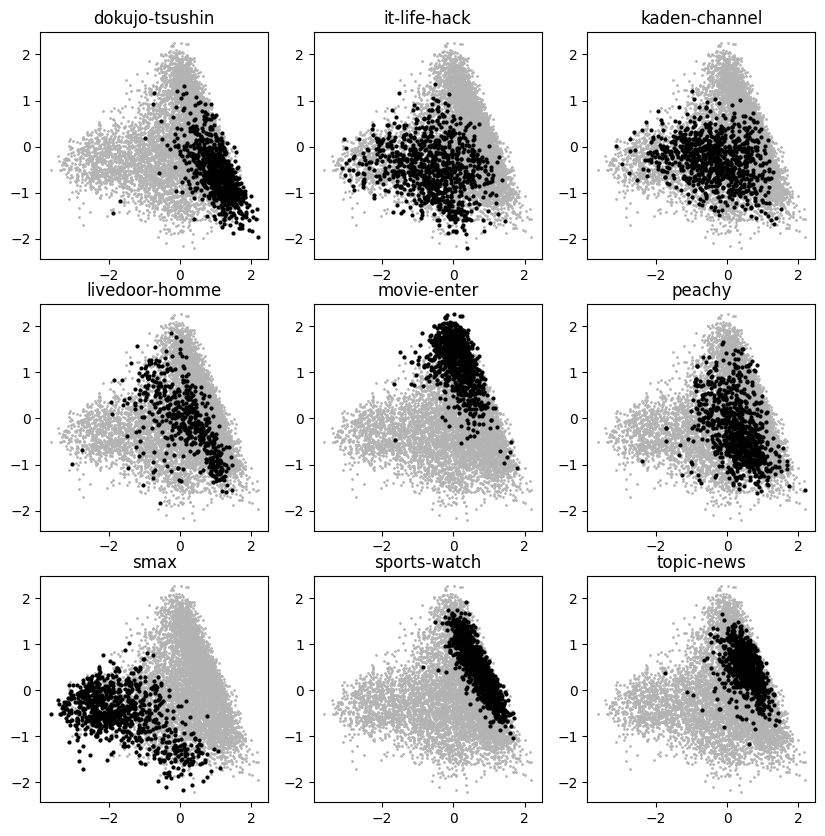

In [7]:
# 10-7
# -------------------------------------------------------------
# 目的（理論）：
# - PCA で 2 次元へ次元圧縮した文ベクトル（sentence_vectors_pca）を、
#   9 カテゴリー（labels ∈ {0..8}）ごとに小 multiples（3×3 サブプロット）で可視化する。
# - 各小図では「全体分布（薄い灰色）」を背景に描き、注目クラスのみ「黒」で上書きすることで、
#   クラスごとのクラスタリング傾向・重なり・境界の曖昧さを視覚的に比較できる。
# - PCA 可視化は「線形・分散最大化」に基づく投影であり、クラス分離が線形でない場合は
#   必ずしも明瞭にならない点に注意（t-SNE/UMAP などの非線形手法も状況によって有効）。
# 前提：
# - sentence_vectors_pca : ndarray 形状 [N, 2]（10-6 で PCA 済み）
# - labels               : ndarray 形状 [N]   （各サンプルのクラスID 0..8）
# - category_list        : 長さ 9 のラベル名リスト（labels の数値に対応）
# -------------------------------------------------------------

plt.figure(figsize=(10, 10))  # 全体キャンバス（インチ）。サブプロットを 3×3 で配置
for label in range(9):
    plt.subplot(3, 3, label + 1)  # 小図を (行=3, 列=3, インデックス=1..9) で配置

    # 対象クラスのブールマスク（True の行だけが該当クラス）
    index = labels == label

    # 背景：全サンプル（灰色・小さめマーカー）
    # ねらい：各クラス図でも “全体の地形” を参照できるようにする（文書密度や他クラスの散らばりがわかる）
    plt.plot(
        sentence_vectors_pca[:, 0],
        sentence_vectors_pca[:, 1],
        "o",
        markersize=1,
        color=[0.7, 0.7, 0.7],
    )

    # 前景：注目クラスのみ（黒・やや大きいマーカー）
    # ねらい：クラスの凝集度・位置・他クラスとの重なりを視認しやすくする
    plt.plot(
        sentence_vectors_pca[index, 0],
        sentence_vectors_pca[index, 1],
        "o",
        markersize=2,
        color="k",
    )

    # 小図タイトルにクラス名を表示（category_list と labels の対応が前提）
    plt.title(category_list[label])

# 備考（任意改善案；ここでは “コード変更はしない” 方針のためコメントのみ）：
# - plt.tight_layout() を最後に呼ぶとタイトルや軸ラベルの重なりを軽減できる。
# - 重なりが多い場合は alpha（透過）を付けると密度が見やすい（例：alpha=0.3）。
# - 座標軸スケール差で歪む場合は plt.axis('equal') や標準化を検討。
# - PCA は分散保持が目的でクラス分離を最適化しない。判別可視化なら LDA（クラス内/間分散比最大化）の併用も検討。

In [ ]:
# 10-8
# -------------------------------------------------------------------
# 目的（理論）：
# - t-SNE（t-Distributed Stochastic Neighbor Embedding）で sentence_vectors（[N, H]）
#   を 2 次元へ非線形射影し、**局所近傍構造の保存**を重視した可視化を得る。
#   PCA と異なり「分散最大化」ではなく、「近い点どうしを近くに、遠い点は緩く離す」ことに最適化される。
#
# 重要な性質・注意点：
# - 非凸最適化で初期値・学習率に敏感 → 結果は再現しにくい。random_state を固定すると比較しやすい。
# - 軸値の意味は薄い（回転・スケールも恣意的）。**クラスター間距離の大小を過度に解釈しない**こと。
# - 計算コストは大きめ（Barnes-Hut/FFT 近似で軽減されるが、N が大きいと時間・メモリを要する）。
# - perplexity は「近傍点の有効サイズ」（だいたい 5〜50）。**n_samples > 3*perplexity** が実質的な下限。
# - 実務定石：まず **PCA で 50 次元程度に圧縮 → t-SNE(2D)**（ノイズ低減と計算短縮）。
#
# 実装メモ：
# - scikit-learn の TSNE は CPU 実装（GPU 依存なし）。Mac/MPS・CUDA の有無に関係なく動作する。
# - 既定パラメータはバージョンで変わることがある（例：learning_rate='auto', init='pca' など）。
#   再現性を重視するなら、perplexity / learning_rate / init / n_iter / random_state を明示すること。
#   （推奨例を下にコメントで提示）
# -------------------------------------------------------------------

# 元のコード（最小指定）：2次元へ射影
sentence_vectors_tsne = TSNE(n_components=2).fit_transform(sentence_vectors)

# -------------------------------------------------------------------
# 推奨の明示パラメータ例（参考：コメントアウト）
# from sklearn.manifold import TSNE
# tsne = TSNE(
#     n_components=2,        # 2次元へ
#     perplexity=30,         # 近傍サイズ（5〜50 で調整。データ密度に依存）
#     learning_rate='auto',  # 収束安定化（scikit-learn>=1.2）
#     init='pca',            # 初期配置（PCA により収束を助ける）
#     n_iter=1000,           # 反復回数（必要なら 2000 以上へ）
#     metric='euclidean',    # 距離（コサインを使うなら metric='cosine'）
#     random_state=42,       # 再現性の担保
#     square_distances=True  # 近似の数値安定性（既定 True）
# )
# # （推奨手順）事前に 50 次元へ PCA 圧縮してから t-SNE：
# # sentence_vectors_50d = PCA(n_components=50).fit_transform(sentence_vectors)
# # sentence_vectors_tsne = tsne.fit_transform(sentence_vectors_50d)
#
# 可視化時の実務ポイント：
# - plt.scatter(..., s=1〜3, alpha=0.2〜0.5, rasterized=True) で重なりと速度を両立
# - クラス別に色分けする場合は凡例よりも小マルチプル（10-7 と同様）が比較しやすい
# - 実験ログに random_state と perplexity・n_iter を必ず記録（再現・比較が容易）

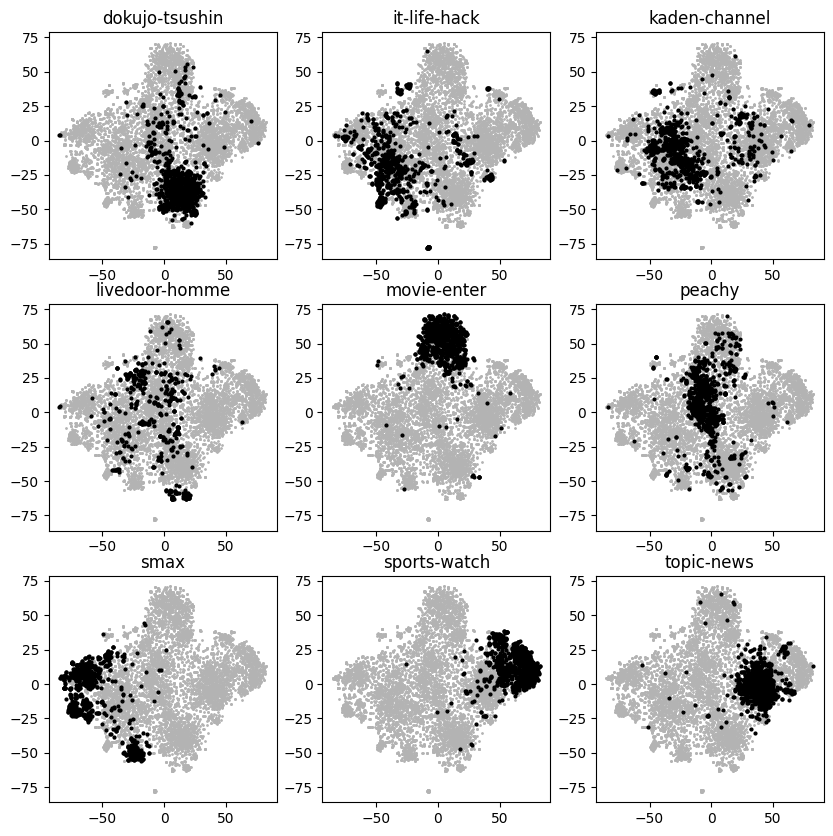

In [9]:
# 10-9
# -------------------------------------------------------------
# 目的（理論）：
# - 10-8 で t-SNE により 2 次元へ非線形射影した文ベクトル
#   （sentence_vectors_tsne ∈ R^{N×2}）を、9 クラスごとの
#   小マルチプル（3×3 サブプロット）で可視化する。
# - 各サブプロットでは「全体分布（薄灰）」を背景に、
#   注目クラスのみ「黒」で重ね描きし、**局所近傍構造**の
#   まとまり・重なり・外れ値傾向を視覚的に比較する。
#
# t-SNE を読む際の注意：
# - t-SNE は局所近傍の保存を最適化する手法であり、
#   軸の数値やクラスター間距離の“絶対的な大きさ”は解釈しない。
#   （回転・スケールが恣意的で、全体幾何は歪むことがある）
# - 初期値・学習率・perplexity・random_state に敏感で再現性が低い。
#   比較実験では必ずパラメータと乱数種をログ化する。
# - N が大きい場合は描画負荷が高くなるため、alpha を下げる、
#   サンプリングする、rasterized=True を利用する等の工夫が有効。
#
# 前提：
# - sentence_vectors_tsne : ndarray 形状 [N, 2]（10-8 で作成済み）
# - labels               : ndarray 形状 [N]   （クラスID 0..8）
# - category_list        : 長さ 9 のクラス名リスト（labels と対応）
# -------------------------------------------------------------

plt.figure(figsize=(10, 10))  # 全体キャンバス（3×3 の小図を並べる）

for label in range(9):
    plt.subplot(3, 3, label + 1)  # サブプロットの配置（1..9）
    index = labels == label  # 対象クラスのブールマスク

    # 背景：全サンプル（薄灰・小さめマーカー）
    # ねらい：各小図でも“全体の地形”を参照し、対象クラスの相対位置を把握する
    plt.plot(
        sentence_vectors_tsne[:, 0],
        sentence_vectors_tsne[:, 1],
        "o",
        markersize=1,
        color=[0.7, 0.7, 0.7],
    )

    # 前景：対象クラスのみ（黒・やや大きいマーカー）
    # ねらい：局所クラスタの凝集度・ばらつき・外れ値を視認しやすくする
    plt.plot(
        sentence_vectors_tsne[index, 0],
        sentence_vectors_tsne[index, 1],
        "o",
        markersize=2,
        color="k",
    )

    # 小図タイトルにクラス名を表示
    plt.title(category_list[label])

# メモ（改善案；ここではコードは変えない）：
# - plt.subplots(sharex=True, sharey=True) で軸を共有するとクラス間比較がしやすい。
# - 描画高速化や重なり可視化には scatter + alpha（例：alpha=0.3）や rasterized=True を検討。
# - t-SNE の結果解釈は「まとまりの有無」「混ざり方の傾向」に留め、
#   距離の絶対値評価やクラス間距離の大小比較には用いない。

In [10]:
# 10-10
# =============================================================================
# 目的（理論）：
# - 文ベクトル間の類似度として **コサイン類似度** を用い，最近傍検索（1-NN）で
#   「入力記事と最も似ている記事」が **同一カテゴリー** かどうかを指標化する。
#   コサイン類似度は，ベクトルを L2 正規化したうえでの内積と等価（[-1, 1] の範囲）。
#
# 数学的背景：
# - 各文ベクトル x_i ∈ ℝ^H を L2 正規化して \tilde{x}_i = x_i / ||x_i|| とすると，
#   類似度 sim(i, j) = \tilde{x}_i^T \tilde{x}_j はコサイン類似度に一致する。
# - 全ペアの類似度行列 S = \tilde{X} \tilde{X}^T（N×N）を作れば，
#   行ごとの argmax で最近傍のインデックス（自己を除く）を得られる。
#
# 実装上の注意：
# - 正規化の分母が 0（全ゼロベクトル）の場合は 0 除算に注意（安全策は下にコメント例）。
# - S は O(N^2) メモリ → N が大きい場合は FAISS/Annoy/HNSW などの近似最近傍で回避を検討。
# - 対角を -1 に潰すことで「自己一致」を除外（すべての非対角が ≥ -1 のため必ず外れる）。
# - この評価は **retrieval@1（1-NN の一致率）** に相当。ラベル不均衡や多峰性の影響に留意。
# =============================================================================

# 先にノルムを1にしておく。
norm = np.linalg.norm(sentence_vectors, axis=1, keepdims=True)
# （安全版の例：ゼロ割防止。必要なら有効化）
# norm_safe = np.where(norm == 0.0, 1e-12, norm)
# sentence_vectors_normalized = sentence_vectors / norm_safe

sentence_vectors_normalized = sentence_vectors / norm

# 類似度行列を計算する。
# 類似度行列の(i,j)要素はi番目の記事とj番目の記事の類似度を表している。
# ここでのドット積は L2 正規化済みのため **コサイン類似度** に一致する。
sim_matrix = sentence_vectors_normalized.dot(sentence_vectors_normalized.T)

# 入力と同じ記事が出力されることを避けるため、
# 類似度行列の対角要素の値を小さくしておく（-1 はコサイン類似度の下限）。
# これにより argmax は必ず「自分以外」を選ぶ。
np.fill_diagonal(sim_matrix, -1)

# 類似度が高い記事のインデックスを得る（retrieval@1）
# ties（同値）発生時は最初の最大要素のインデックスが返る点に注意。
similar_news = sim_matrix.argmax(axis=1)

# 類似文章検索により選ばれた記事とカテゴリーが同一であった記事の割合を計算
# この値は **Top-1 近傍が同一ラベル** である割合＝1-NN 一致率（分類的に言えば「1-NN 精度」）に相当。
input_news_categories = labels
output_news_categories = labels[similar_news]
num_correct = (input_news_categories == output_news_categories).sum()
accuracy = num_correct / labels.shape[0]

print(f"Accuracy: {accuracy:.2f}")

# -----------------------------------------------------------------------------
# 改善のアイデア（必要に応じて検討；ここではコード変更はしない）：
# - Top-k 精度：sim_matrix.argsort(axis=1) の上位 k で同一ラベルが含まれる割合（Recall@k / Precision@k）。
# - 閾値付き検索：cos 類似度が τ 未満なら「近傍なし」とみなす（ノイズ抑制）。
# - ベクトルの事前処理：mean-pooling 後の L2 正規化はコサイン幾何と整合的。加えて PCA→白色化→L2 で安定化するケースあり。
# - 大規模化：O(N^2) を避けるため FAISS（Inner Product＝コサインへ転用可）で近似最近傍。
# - ラベル不均衡：マクロ平均（クラス別の一致率を平均）も併記すると解釈が健全になる。
# -----------------------------------------------------------------------------

Accuracy: 0.83
